In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import impyute
from utils.data_process import mean_normalize
from utils.visualize import custom_histogram
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Continuous data preparation
## 1. Load data + visualize

In [2]:
# Specify directory
temp_data_dir = '../data/temp/'

# Save data 
X_train = pd.read_csv(temp_data_dir + 'X_train.csv', index_col = 0)
y_train = pd.read_csv(temp_data_dir + 'y_train.csv', index_col = 0)
X_dev = pd.read_csv(temp_data_dir + 'X_dev.csv', index_col = 0)
y_dev = pd.read_csv(temp_data_dir + 'y_dev.csv', index_col = 0)

In [31]:
# Select data and specify output filename
df = X_train
y = y_train
filename = "X_train"

# Visualize all continuous variables 
columns_cont = [] 

for i in df.dtypes.index:
    if df.dtypes.loc[i] == 'float64':
        columns_cont.append(i)

In [4]:
df[columns_cont].dtypes

age    float64
TSH    float64
T3     float64
TT4    float64
T4U    float64
FTI    float64
dtype: object

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 1440x1440 with 0 Axes>

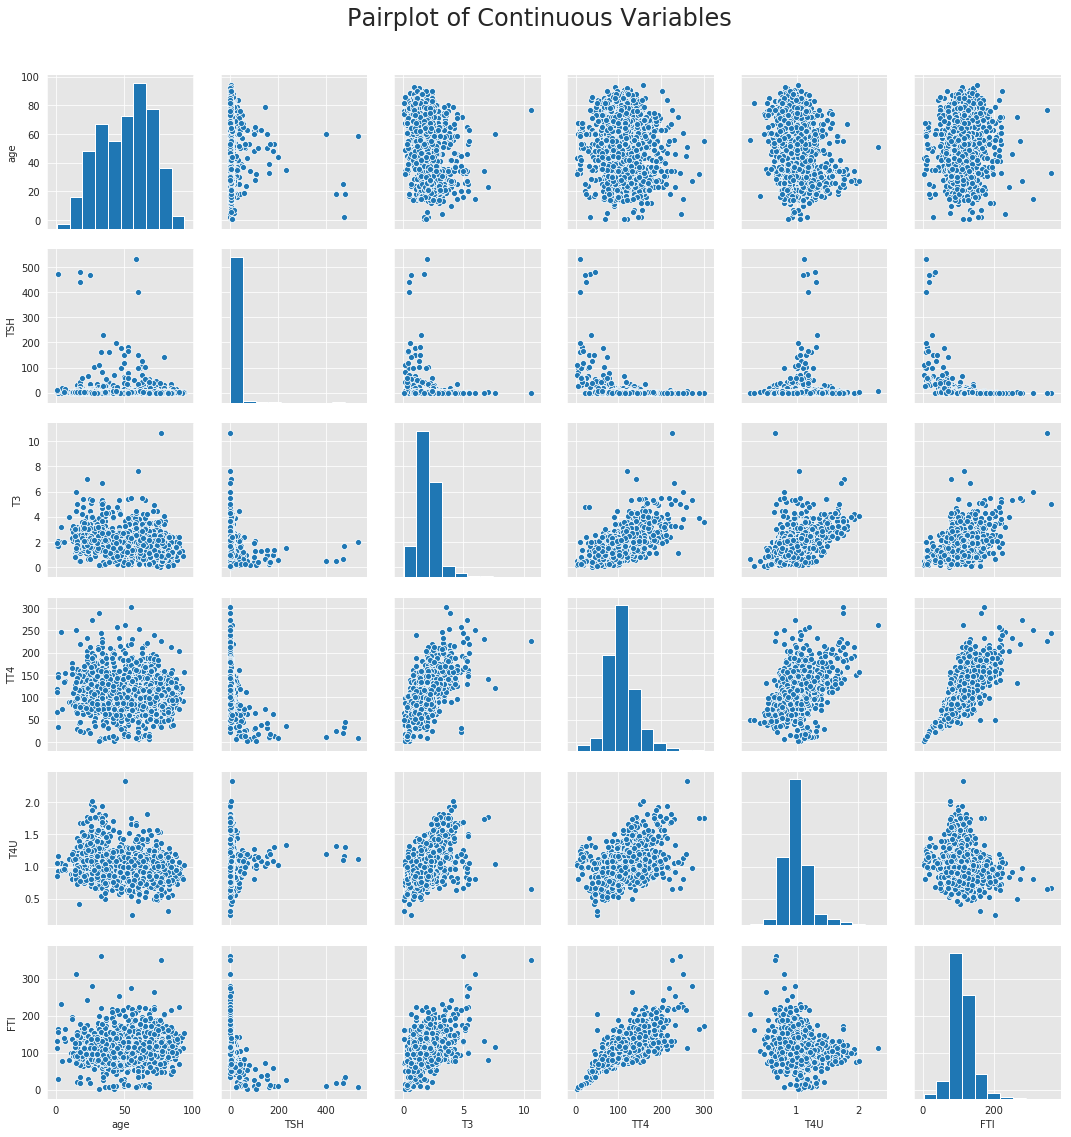

In [5]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(20,20))

fig = sns.pairplot(data=df[columns_cont])
fig.fig.suptitle('Pairplot of Continuous Variables', y=1.05, fontsize=24)
fig.savefig('../images/pairplot_continous_variables.png')

In [6]:
# Check Sparsity of data
for c in df.columns: 
    missing = df[c].isna().sum()
    if missing > 0: 
        print('{} - dtype: {}'.format(c, df.dtypes.loc[c]))
        print("missing: {}".format(missing))
        print("percent: {:1.4f}".format((missing/df.shape[0]) * 100))
#     else:
#         print(c)
#         print('No missing values\n')

TSH - dtype: float64
missing: 234
percent: 9.6975
T3 - dtype: float64
missing: 470
percent: 19.4778
TT4 - dtype: float64
missing: 139
percent: 5.7605
T4U - dtype: float64
missing: 252
percent: 10.4434
FTI - dtype: float64
missing: 251
percent: 10.4020


In [7]:
# Proportion of rows with missing values
empty_rows = df.isnull().values.ravel().sum()
print('missing rows: {}\npercent: {:.4f}'.format(empty_rows, (empty_rows / df.shape[0])*100))

missing rows: 1346
percent: 55.7812


In [8]:
# Proportion of missing values
empty_cells = df.isna().sum().values.sum()
print("missing cells: {}\npercent: {:4f}".format(empty_cells, (empty_cells / (df.shape[0] * df.shape[1]))*100))

missing cells: 1346
percent: 2.065970


## 2. Replace missing values

### 1. Replace 'age' values with column averages
Since there is only 1 missing age in the entire dataset, filling it with the column aveage should be sufficient. 

In [9]:
if df["age"].isna().sum() > 0: 
    # Impute column average for age (only 1 missing value)
    df['age'].fillna(df['age'].mean(), inplace=True)
    print('Values imputed')
else:
    print('No missing values')

No missing values


### 2. Fill missing values
Most of these column values are missing a significant number of values. 
Simply filling these values with column means may not be sufficient

In [10]:
df[columns_cont[1:]].describe()

,TSH,T3,TT4,T4U,FTI
count,2179.000000,1943.000000,2274.000000,2161.000000,2162.000000
mean,5.655654,2.018605,107.905453,0.994514,110.347965
std,28.644154,0.823365,34.168333,0.196896,32.339116
min,0.005000,0.050000,2.900000,0.250000,2.800000
25%,0.420000,1.600000,88.000000,0.880000,92.000000
50%,1.300000,2.000000,103.000000,0.980000,107.000000
75%,2.700000,2.400000,124.000000,1.080000,124.750000
max,530.000000,10.600000,301.000000,2.320000,362.000000


Most of these codes corresponding to blood test commonly used to identify thyroid disease, thus are expected to have high importance towards predictability. 

Although column T3 has almost 20% of values missing, accorinding to the [American Thyroid Association](https://www.thyroid.org/thyroid-function-tests/), T4 is a useful for hyperthyroidism diagnosis, as patients will have an elevated T3 level. T3 testing is rarely helpful for the patient since it is the last of the test to be administered. 
This may help to explain whey many patients do not have values for this test. 

In [11]:
df[columns_cont].head()

,age,TSH,T3,TT4,T4U,FTI
1753,61.0,1.20,NaN,93.0,0.94,98.0
1754,38.0,0.10,1.5,106.0,0.79,134.0
1050,37.0,0.25,2.0,83.0,1.14,72.0
439,30.0,1.90,NaN,98.0,0.99,99.0
2538,72.0,1.40,1.4,115.0,0.97,118.0


We see that T3 has the most predictive value for XGboost, thus
we want to avoid dropping this column. 
1. Fill in these values with column averages

In [12]:
# Column mean without 0 values
df['T3'].mean()

2.0186052496139992

In [13]:
# Column mean with 0 values
df['T3'].fillna(0).mean()

1.6254247824285122

There is significant difference. For the normalization step, perform with mean without 0's

### 3. Normalize data

In [14]:
# Normalize while keeping NaN values. 
normalized_values = mean_normalize(df[columns_cont])
normalized_values.head()

,age,TSH,T3,TT4,T4U,FTI
1753,0.499352,-0.155552,NaN,-0.436236,-0.276865,-0.381828
1754,-0.712752,-0.193954,-0.629861,-0.055767,-1.038689,0.731375
1050,-0.765452,-0.188718,-0.022597,-0.728905,0.738900,-1.185807
439,-1.134354,-0.131114,NaN,-0.289902,-0.022924,-0.350905
2538,1.079055,-0.148570,-0.751314,0.207635,-0.124501,0.236619


In [15]:
# Create copy 
norm_df = df.copy()

In [16]:
norm_df[columns_cont] = normalized_values
norm_df.head()

,age,M,F,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,...,TSH,T3,TT4,T4U,FTI,STMW,SVHC,SVHD,SVI,other
1753,0.499352,1,0,0,0,0,0,0,0,0,...,-0.155552,NaN,-0.436236,-0.276865,-0.381828,0,0,0,1,0
1754,-0.712752,1,0,0,0,0,0,0,0,0,...,-0.193954,-0.629861,-0.055767,-1.038689,0.731375,0,0,0,1,0
1050,-0.765452,1,0,0,0,0,0,0,0,0,...,-0.188718,-0.022597,-0.728905,0.738900,-1.185807,0,0,0,0,1
439,-1.134354,0,1,0,0,0,0,0,0,0,...,-0.131114,NaN,-0.289902,-0.022924,-0.350905,0,0,0,0,1
2538,1.079055,0,1,0,0,0,0,0,0,0,...,-0.148570,-0.751314,0.207635,-0.124501,0.236619,0,1,0,0,0


In [17]:
# Save normalized file
norm_df.to_csv(temp_data_dir + "{}.normalized.csv".format(filename))

### 4. Impute values with KNN

In [18]:
# Impute values with KNN 
norm_df[columns_cont[1:]].head()

,TSH,T3,TT4,T4U,FTI
1753,-0.155552,NaN,-0.436236,-0.276865,-0.381828
1754,-0.193954,-0.629861,-0.055767,-1.038689,0.731375
1050,-0.188718,-0.022597,-0.728905,0.738900,-1.185807
439,-0.131114,NaN,-0.289902,-0.022924,-0.350905
2538,-0.148570,-0.751314,0.207635,-0.124501,0.236619


In [19]:
# Default k = 3
knn_values = impyute.imputation.cs.fast_knn(norm_df[columns_cont[1:]].to_numpy())

In [20]:
knn_values = pd.DataFrame(knn_values, index=df.index, columns=columns_cont[1:])
knn_values.head()

,TSH,T3,TT4,T4U,FTI
1753,-0.155552,-0.008126,-0.436236,-0.276865,-0.381828
1754,-0.193954,-0.629861,-0.055767,-1.038689,0.731375
1050,-0.188718,-0.022597,-0.728905,0.738900,-1.185807
439,-0.131114,0.031474,-0.289902,-0.022924,-0.350905
2538,-0.148570,-0.751314,0.207635,-0.124501,0.236619


In [21]:
# Create copy
knn_df = df.copy()
knn_df[columns_cont[1:]] = knn_values
knn_df.head()

,age,M,F,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,...,TSH,T3,TT4,T4U,FTI,STMW,SVHC,SVHD,SVI,other
1753,61.0,1,0,0,0,0,0,0,0,0,...,-0.155552,-0.008126,-0.436236,-0.276865,-0.381828,0,0,0,1,0
1754,38.0,1,0,0,0,0,0,0,0,0,...,-0.193954,-0.629861,-0.055767,-1.038689,0.731375,0,0,0,1,0
1050,37.0,1,0,0,0,0,0,0,0,0,...,-0.188718,-0.022597,-0.728905,0.738900,-1.185807,0,0,0,0,1
439,30.0,0,1,0,0,0,0,0,0,0,...,-0.131114,0.031474,-0.289902,-0.022924,-0.350905,0,0,0,0,1
2538,72.0,0,1,0,0,0,0,0,0,0,...,-0.148570,-0.751314,0.207635,-0.124501,0.236619,0,1,0,0,0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


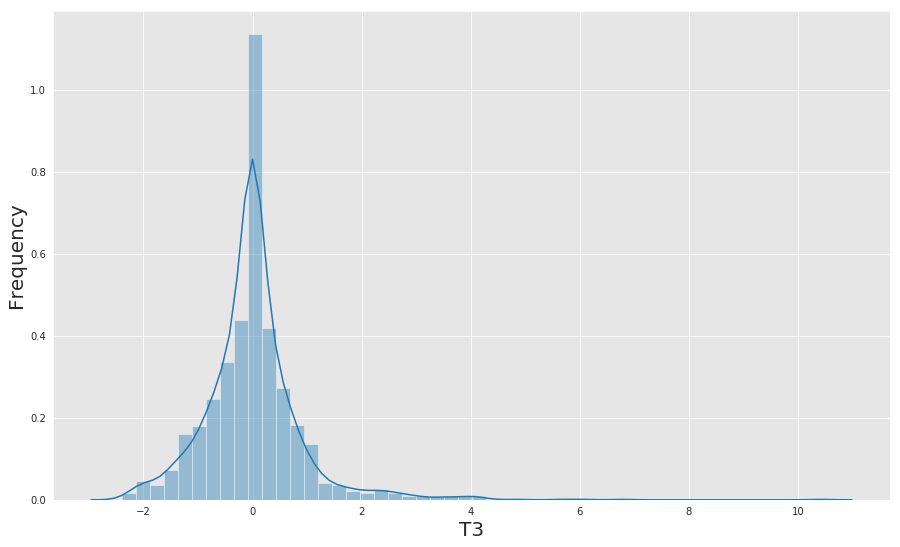

In [22]:
custom_histogram(knn_df, 'T3')

In [23]:
# Save knn impyuted values
knn_df.to_csv(temp_data_dir + "{}.knn.normalized.csv".format(filename))

### 3. PCA of important features as returned by model
- Use the knn_df as this data has been imputed with values
- Must impute empty values or drop as SVD requires all values

In [24]:
# Singular value decomposition of data
U, S, Vh = np.linalg.svd(knn_df[columns_cont[1:]], full_matrices=False)
print(U.shape, S.shape, Vh.shape)

(2413, 5) (5,) (5, 5)


In [25]:
# Eigenvalues
pd.DataFrame(np.diag(S))

,0,1,2,3,4
0,70.508319,0.000000,0.000000,0.000000,0.000000
1,0.000000,54.024056,0.000000,0.000000,0.000000
2,0.000000,0.000000,41.051084,0.000000,0.000000
3,0.000000,0.000000,0.000000,32.791199,0.000000
4,0.000000,0.000000,0.000000,0.000000,8.596887


In [26]:
# Get the principal components by multiplying right eigenvectors with eigenvalues 
svd_score = np.matmul(U, np.diag(S))
svd_score.shape
PC1 = svd_score[:,0]    
PC2 = svd_score[:,1]
PC3 = svd_score[:,2]
PC4 = svd_score[:,3]

In [27]:
pca_data = pd.DataFrame.from_dict({'pc1': PC1,
                                   'pc2': PC2,
                                   'pc3': PC3,
                                   'pc4': PC4})
print(pca_data.shape)
pca_data.head()

(2413, 4)


,pc1,pc2,pc3,pc4
0,0.496047,0.131486,0.329558,-0.246657
1,0.119171,1.363104,-0.389028,0.155927
2,0.846471,-0.941864,0.952937,0.037188
3,0.316575,-0.075104,0.318306,-0.132934
4,0.050008,0.468502,-0.109361,0.683358


In [32]:
cat = y['Class'].astype('category')
cat = cat.cat.codes
cat.head()

1753    0
1754    0
1050    0
439     0
2538    0
dtype: int8

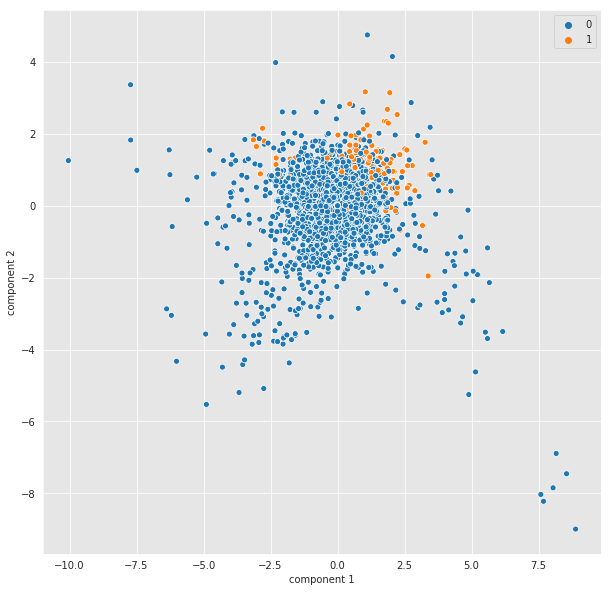

In [33]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pc1", y="pc2", data=pca_data, hue=cat.values)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

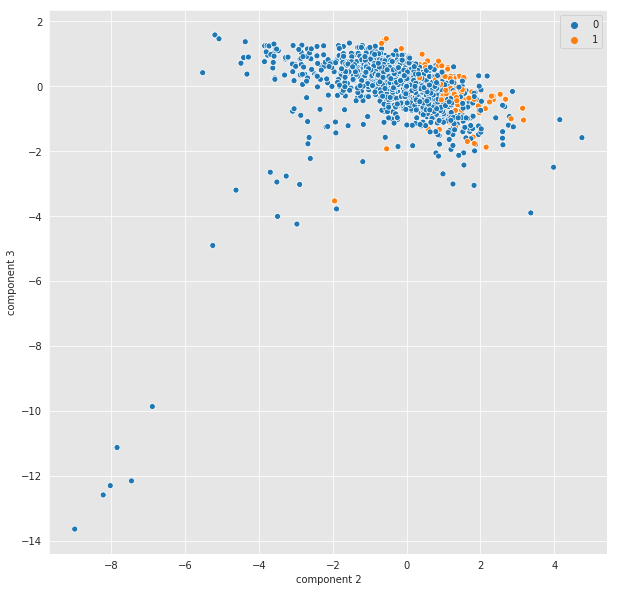

In [34]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pc2", y="pc3", data=pca_data, hue=cat.values)
plt.xlabel('component 2')
plt.ylabel('component 3')
plt.show()

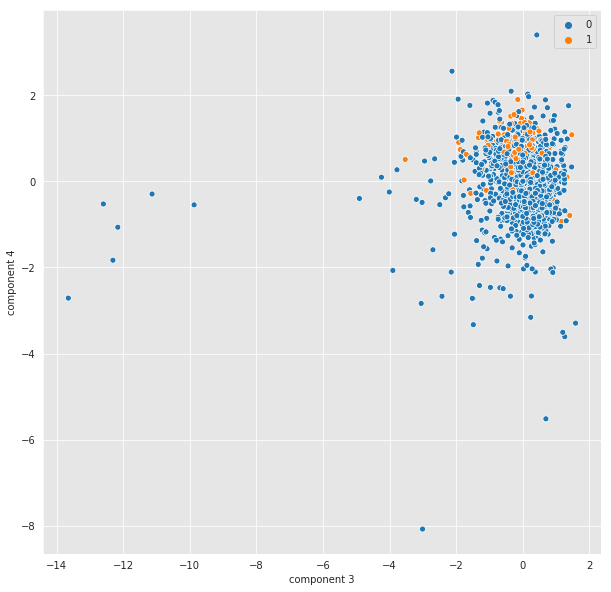

In [35]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pc3", y="pc4", data=pca_data, hue=cat.values)
plt.xlabel('component 3')
plt.ylabel('component 4')
plt.show()

In [36]:
# Add correct index values
pca_data.index = df.index
pca_data.head()

,pc1,pc2,pc3,pc4
1753,0.496047,0.131486,0.329558,-0.246657
1754,0.119171,1.363104,-0.389028,0.155927
1050,0.846471,-0.941864,0.952937,0.037188
439,0.316575,-0.075104,0.318306,-0.132934
2538,0.050008,0.468502,-0.109361,0.683358


In [37]:
pca_df = pd.concat([knn_df, pca_data], axis=1)

In [38]:
# Save knn impyuted values
pca_df.to_csv(temp_data_dir + "{}.pca.knn.normalized.csv".format(filename))

In [ ]:
'X_dev.csv',
 'y_dev.csv',
 'X_train.knn.normalized.csv',
 'X_train.zeros.csv',
 'X_train.pca.knn.normalized.csv',
 'X_dev.zeros.csv',
 'X_dev.pca.knn.normalized.csv',
 'X_dev.normalized.csv',
 'X_train.csv',
 'X_train.normalized.csv',
 'y_train.csv']
